#**Deep Learning Homework 4: Recurrent Neural Networks & Transformer**
---
In this homework, we will explore how to develop a simple Recurrent Neural Network (RNN) for sentiment analysis. We will use the IMDB dataset---it contains the text of some reviews and the sentiment given by their authors (either positive or negative). The input to the RNN is the sequence of words that compose a review, so the learning task consists in predicting the overall sentiment of the review.
In the first part, we will learn how to develop a simple RNN, then we will explore the differences in terms of computational load, number of parameters, and performances with respect to more advanced recurrent models, like LSTM and GRU. Subsequently, we experiment with the bi-directional model to unveil the strengths and the weaknesses of this technique. Finally, we will solve the same classification problem with a Transformer, in order to have a closer look at its internal functioning.

**NOTE**: in order to run this notebook without problems, please connect to a *GPU runtime*. You can do so by clicking on the RAM / Disk icon in the upper right part of the notebook, then on *Change runtime type* at the bottom of the page, and then select the GPU hardware accelerator.  

##Exercise 4.1: Simple RNN

Let's start by importing Tensorflow, Keras and Numpy

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

np.random.seed(42)

###Load dataset:
In this HW, we use the same datset used in the HW2, the IMDB dataset. The dataset contains 50,000 movie reviews from IMDB, labeled by sentiment (positive/negative). Reviews have been preprocessed, and each review is encoded as a sequence of word indexes. For convenience, the words are indexed by the overall frequency in the dataset, so that for example the integer "3" encodes the 3rd most frequent word in the data. For testing purposes, we will only consider the first 10,000  most common words.
By default, the load_data method returns a breakdown of the dataset into training and test sets. Both these sets contain 25,000 samples. To also have a validation set, we split the test set in half.

In [2]:
num_words = 10000
(X_train, y_train), (X_test, y_test) = keras.datasets.imdb.load_data(num_words=num_words)
(X_valid, X_test) = X_test[:12500], X_test[12500:]
(y_valid, y_test) = y_test[:12500], y_test[12500:]

17473536/17464789 [==============================] - 0s 0us/step


Let's also get the word indexs (word to word-id)

In [3]:
word_index = keras.datasets.imdb.get_word_index()

1654784/1641221 [==============================] - 0s 0us/step


Now we create a reverse index (word-id to word) method. Moreover, we add three special word-ids to encode:
- the padding;
- the start of a sequence;
- a word that is not in the vocabulary of the first 10,000 most common words.

Moreover, we also add an "unknown" placeholder for all the other symbols (not words) that may occur. Notice that Keras does not use index 0, so we can shift the indices only by 3 positions.

In [4]:
reverse_index = {word_id + 3: word for word, word_id in word_index.items()}
reverse_index[0] = "<pad>" # padding
reverse_index[1] = "<sos>" # start of sequence
reverse_index[2] = "<oov>" # out-of-vocabulary
reverse_index[3] = "<unk>" # unknown

def decode_review(word_ids):
    return " ".join([reverse_index.get(word_id, "<err>") for word_id in word_ids])

Let's print a training sample and its target value

In [5]:
decode_review(X_train[0])

"<sos> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <oov> is an amazing actor and now the same being director <oov> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <oov> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <oov> to the two little boy's that played the <oov> of norman and paul they were just brilliant children are often left out of the <oov> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what

In [6]:
y_train[0]

1

Because of a limit of Keras, to feed the input data into an RNN model we have to create sequences that have the same length. We use keras.preprocessing.sequence.pad_sequences() to preprocess X_train: this will create a 2D array of 25,000 rows (one per review) and maxlen=500 columns. Because of that, reviews longer than 500 words will be cut, while reviews shorter than 500 words will be padded with zeros.

In [7]:
maxlen = 500
X_train_trim = keras.preprocessing.sequence.pad_sequences(X_train, maxlen=maxlen)
X_test_trim = keras.preprocessing.sequence.pad_sequences(X_test, maxlen=maxlen)
X_valid_trim = keras.preprocessing.sequence.pad_sequences(X_valid, maxlen=maxlen)

### Model Definition
Let's define the model: 
- The first layer is an Embedding layer, with input_dim=num_words and output_dim=10. The model will gradually learn to represent each of the 10,000 words as a 10-dimensional vector. So the next layer will receive 3D batches of shape (batch size, 500, 10)
- The second layer is the recurrent one. In particular, in this case, we use a [SimpleRNN](https://www.tensorflow.org/api_docs/python/tf/keras/layers/SimpleRNN) 
- The output layer 



Considering we're dealing with a classification problem, it makes sense to have the network produce (for each observation) a probability score for each class, and then use these probability scores to classify the observation.

Usually we would pick the softmax as activation function on the output layer, in this case though we're facing a binary classification problem, so it suffices to produce in output just a single probability score, indicating the probability to belong to one of the two classes, say $P(y_{i}=1 | x_{i})$.

From this probability score we can then deduce also $P(y_{i}=0 | x_{i}) = 1-P(y_{i}=1 | x_{i})$.

So we consider an output layer with just 1 unit and the sigmoid activation function, since this outputs a value in $(0, 1)$ which can be interpreted as a probability density. Consequently we can choose the binary cross-entropy as loss function. 

In [8]:
model = keras.models.Sequential()
model.add(keras.layers.Embedding(input_dim=num_words, output_dim=10))
model.add(keras.layers.SimpleRNN(units=32))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer="adam", metrics=["accuracy"])

Let's print a summary of the model. Specifically, note the number of parameters of the RNN layer.

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 10)          100000    
                                                                 
 simple_rnn (SimpleRNN)      (None, 32)                1376      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 101,409
Trainable params: 101,409
Non-trainable params: 0
_________________________________________________________________


Now we have to train the model:

In [10]:
history = model.fit(X_train_trim, y_train,
                    epochs=10, batch_size=128, validation_data=(X_valid_trim, y_valid))

Epoch 1/10
196/196 [==============================] - 33s 160ms/step - loss: 0.6856 - accuracy: 0.5465 - val_loss: 0.6542 - val_accuracy: 0.6562
Epoch 2/10
196/196 [==============================] - 29s 148ms/step - loss: 0.5202 - accuracy: 0.7594 - val_loss: 0.4688 - val_accuracy: 0.7854
Epoch 3/10
196/196 [==============================] - 29s 148ms/step - loss: 0.3984 - accuracy: 0.8198 - val_loss: 0.3917 - val_accuracy: 0.8334
Epoch 4/10
196/196 [==============================] - 29s 148ms/step - loss: 0.2588 - accuracy: 0.8971 - val_loss: 0.3698 - val_accuracy: 0.8534
Epoch 5/10
196/196 [==============================] - 29s 148ms/step - loss: 0.1862 - accuracy: 0.9320 - val_loss: 0.3991 - val_accuracy: 0.8521
Epoch 6/10
196/196 [==============================] - 29s 148ms/step - loss: 0.1328 - accuracy: 0.9550 - val_loss: 0.4197 - val_accuracy: 0.8358
Epoch 7/10
196/196 [==============================] - 29s 149ms/step - loss: 0.0965 - accuracy: 0.9706 - val_loss: 0.4550 - val_ac

Print the values of accuracy and the loss , and evaluate the model on the test set

391/391 - 10s - loss: 0.5489 - accuracy: 0.8450 - 10s/epoch - 26ms/step
accuracy: 84.50%


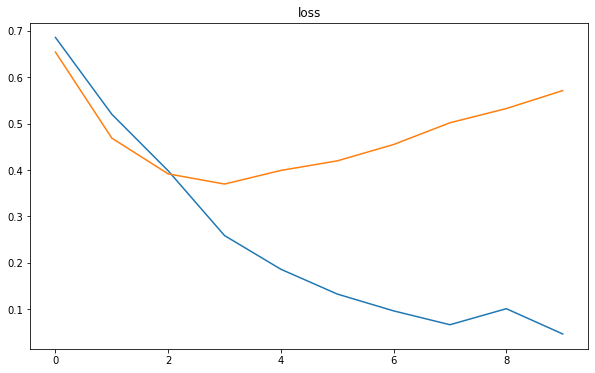

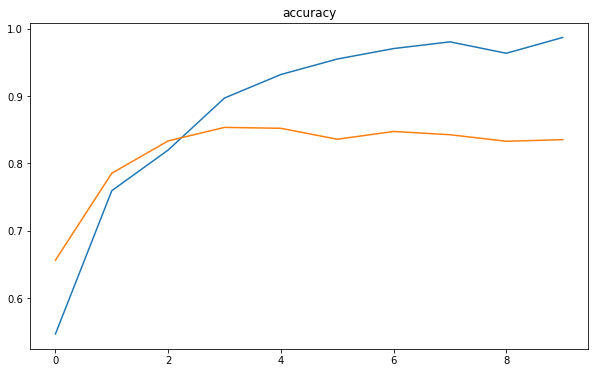

In [11]:
def plot_loss(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch, history.history['loss'])
  plt.plot(history.epoch, history.history['val_loss'])
  plt.title('loss')

def plot_accuracy(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch, history.history['accuracy'])
  plt.plot(history.epoch, history.history['val_accuracy'])
  plt.title('accuracy')

plot_loss(history)

plot_accuracy(history)

scores = model.evaluate(X_test_trim, y_test, verbose=2)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

## Exercise 4.2: LSTM and GRU
In this Exercise, we implement 2 models, similar to the previous one that, instead of exploiting the RNN layer, use an LSTM and a GRU Layer respectively. Then, we train them and plot the values of accuracy and loss. Finally, we discuss the differences in terms of performance, the number of parameters, and training time.

In [12]:
# LSTM model

model_LSTM = keras.models.Sequential()
model_LSTM.add(keras.layers.Embedding(input_dim=num_words, output_dim=10))
model_LSTM.add(keras.layers.LSTM(units=52))
model_LSTM.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model_LSTM.compile(loss='binary_crossentropy', optimizer="adam", metrics=["accuracy"])

In [13]:
model_LSTM.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 10)          100000    
                                                                 
 lstm (LSTM)                 (None, 52)                13104     
                                                                 
 dense_1 (Dense)             (None, 1)                 53        
                                                                 
Total params: 113,157
Trainable params: 113,157
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history_LSTM = model_LSTM.fit(X_train_trim, y_train,
                    epochs=10, batch_size=128, validation_data=(X_valid_trim, y_valid))

Epoch 1/10
196/196 [==============================] - 118s 589ms/step - loss: 0.5224 - accuracy: 0.7421 - val_loss: 0.3604 - val_accuracy: 0.8442
Epoch 2/10
196/196 [==============================] - 103s 528ms/step - loss: 0.3547 - accuracy: 0.8540 - val_loss: 0.3386 - val_accuracy: 0.8549
Epoch 3/10
196/196 [==============================] - 103s 524ms/step - loss: 0.4255 - accuracy: 0.7970 - val_loss: 0.3226 - val_accuracy: 0.8687
Epoch 4/10
196/196 [==============================] - 103s 525ms/step - loss: 0.2118 - accuracy: 0.9183 - val_loss: 0.3258 - val_accuracy: 0.8778
Epoch 5/10
196/196 [==============================] - 103s 524ms/step - loss: 0.1640 - accuracy: 0.9428 - val_loss: 0.3124 - val_accuracy: 0.8748
Epoch 6/10
196/196 [==============================] - 103s 525ms/step - loss: 0.1394 - accuracy: 0.9525 - val_loss: 0.3547 - val_accuracy: 0.8738
Epoch 7/10
196/196 [==============================] - 102s 521ms/step - loss: 0.1361 - accuracy: 0.9520 - val_loss: 0.3992 -

391/391 - 20s - loss: 0.4034 - accuracy: 0.8558 - 20s/epoch - 51ms/step
accuracy: 85.58%


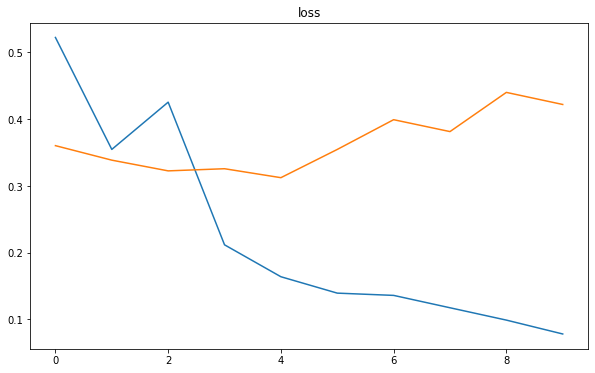

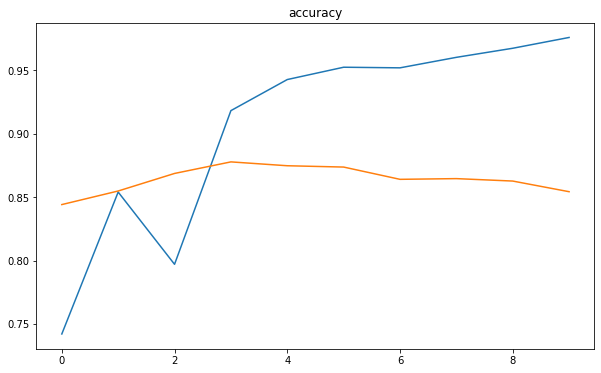

In [ ]:
plot_loss(history_LSTM)

plot_accuracy(history_LSTM)

scores_LSTM = model_LSTM.evaluate(X_test_trim, y_test, verbose=2)
print("%s: %.2f%%" % (model_LSTM.metrics_names[1], scores_LSTM[1]*100))

In [14]:
# GRU model

model_GRU = keras.models.Sequential()
model_GRU.add(keras.layers.Embedding(input_dim=num_words, output_dim=10))
model_GRU.add(keras.layers.GRU(units=20))
model_GRU.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model_GRU.compile(loss='binary_crossentropy', optimizer="adam", metrics=["accuracy"])

In [15]:
model_GRU.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 10)          100000    
                                                                 
 gru (GRU)                   (None, 20)                1920      
                                                                 
 dense_2 (Dense)             (None, 1)                 21        
                                                                 
Total params: 101,941
Trainable params: 101,941
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history_GRU = model_GRU.fit(X_train_trim, y_train,
                    epochs=10, batch_size=128, validation_data=(X_valid_trim, y_valid))

Epoch 1/10
196/196 [==============================] - 55s 272ms/step - loss: 0.5534 - accuracy: 0.6981 - val_loss: 0.4097 - val_accuracy: 0.8166
Epoch 2/10
196/196 [==============================] - 53s 271ms/step - loss: 0.2929 - accuracy: 0.8813 - val_loss: 0.3299 - val_accuracy: 0.8660
Epoch 3/10
196/196 [==============================] - 54s 275ms/step - loss: 0.2459 - accuracy: 0.9053 - val_loss: 0.3455 - val_accuracy: 0.8634
Epoch 4/10
196/196 [==============================] - 53s 271ms/step - loss: 0.1860 - accuracy: 0.9324 - val_loss: 0.3364 - val_accuracy: 0.8692
Epoch 5/10
196/196 [==============================] - 53s 272ms/step - loss: 0.1550 - accuracy: 0.9470 - val_loss: 0.3637 - val_accuracy: 0.8643
Epoch 6/10
196/196 [==============================] - 53s 271ms/step - loss: 0.1321 - accuracy: 0.9565 - val_loss: 0.3936 - val_accuracy: 0.8545
Epoch 7/10
196/196 [==============================] - 54s 273ms/step - loss: 0.1203 - accuracy: 0.9610 - val_loss: 0.4373 - val_ac

391/391 - 11s - loss: 0.4509 - accuracy: 0.8525 - 11s/epoch - 29ms/step
accuracy: 85.25%


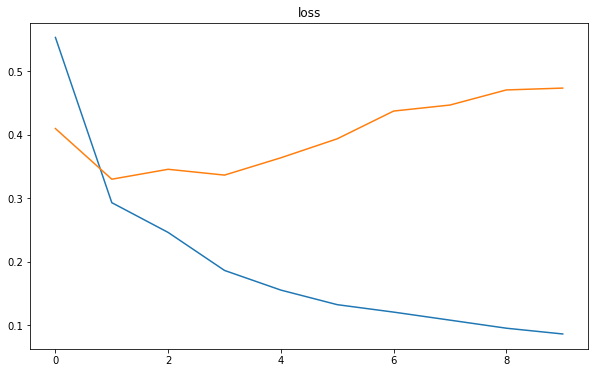

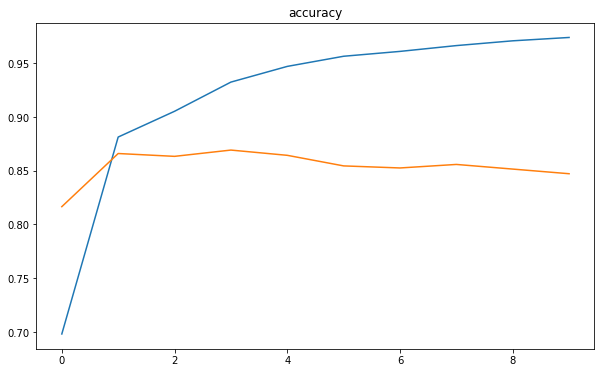

In [ ]:
plot_loss(history_GRU)

plot_accuracy(history_GRU)

scores_GRU = model_GRU.evaluate(X_test_trim, y_test, verbose=2)
print("%s: %.2f%%" % (model_GRU.metrics_names[1], scores_GRU[1]*100))

First of all we report the achieved accuracy scores for both models:

* LSTM model (52 units on LSTM layer): accuracy = 85.58%
* GRU model (20 units on GRU layer): accuracy = 85.25%

Surprisingly, choosing wisely the number of parameters the GRU model seems to perform as good as the LSTM model in terms of accuracy score, and even better in terms of computing time and number of parameters.\
In fact, the GRU model was able to reach accuracy levels comparable to the ones of LSTM model with more than 10000 parameters less, and in about half of the time!\
We also notice that both the models seem to overfit.




In order to perform a fair comparison (definition of fair: models have to use more or less the same number of parameters) between the given RNN model and the other 2 models (LSTM and GRU), how many units do they have to use?




Let's start by examining the structure of the hidden units $h_{t}$ for the three different models. Let's suppose $x_{t}\in\mathbb{R}^{n}$ and $h_{t}\in\mathbb{R}^{m} \quad \forall t = 1, \dots, \tau$.\
To further simplify the discussion let's also assume all the involved activation functions to be either $tanh(⋅)$ or $\sigma(⋅)$.

* In the simple RNN, generally we have
\begin{equation*}
    h_{t} = \tanh{\left(Ux_{t}+Wh_{t-1}+b\right)}
\end{equation*}
where $U\in\mathbb{R}^{m\times n},\: W\in\mathbb{R}^{m\times m},\: b\in\mathbb{R}^{m}$. In total there are $mn+m^{2}+m$ parameters on the hidden layer.

* If now $h_{t}$ is an LSTM unit, then in general we have
\begin{equation*}
    s_{t} = f_{t}\odot s_{t-1}+g_{t}\odot \sigma\left(Ux_{t}+Wh_{t-1}+b\right)
\end{equation*}
and
\begin{equation*}
    h_{t} = o_{t}\odot \tanh{(s_{t})}
\end{equation*}
where $f_{t},\; g_{t},\; o_{t}$ are respectively the forget, input and output gates, parameterized as follows
\begin{equation*}
f_{t} = \sigma(U^{f}x_{t}+W^{f}h_{t-1}+b^{f})    
\end{equation*}
\begin{equation*}
g_{t} = \sigma(U^{g}x_{t}+W^{g}h_{t-1}+b^{g})    
\end{equation*}
\begin{equation*}
o_{t} = \sigma(U^{o}x_{t}+W^{o}h_{t-1}+b^{o}).
\end{equation*}
Here $s_{t}$ is the vector of state units of the LSTM circuit at time $t$ and $\odot$ denotes the component-wise product.
So we have 
  - $U, U^{f}, U^{g}, U^{o}\in\mathbb{R}^{m\times n}$;
  - $W, W^{f}, W^{g}, W^{o} \in \mathbb{R}^{m\times m}$;
  - $b, b^{f}, b^{g}, b^{o} \in \mathbb{R}^{m}$, 

 for a total of $4\cdot (mn+m^{2}+m)$ parameters.

* If now $h_{t}$ is a GRU unit, then generally we have
\begin{equation*}
    h_{t} = z_{t}\odot h_{t-1}+(1-z_{t})\odot \sigma(Ux_{t}+W(r_{t} \odot h_{t-1})+b)
\end{equation*}
where $z_{t}$ and $r_{t}$ are gated units parameterized as
\begin{equation*}
z_{t} = \sigma(U^{z}x_{t}+W^{z}h_{t-1}+b^{z})    
\end{equation*}
\begin{equation*}
r_{t} = \sigma(U^{r}x_{t}+W^{r}h_{t-1}+b^{r})    
\end{equation*}
So we have 
  - $U, U^{z}, U^{r}\in\mathbb{R}^{m\times n}$;
  - $W, W^{z}, W^{r}\in \mathbb{R}^{m\times m}$;
  - $b, b^{z}, b^{r}\in \mathbb{R}^{m}$,
  
  for a total of $3\cdot (mn+m^{2}+m)$ parameters.
  Notice though that keras adds two bias vectors in each component (because of reset_after=True), so the total number of parameters in our case is given by $3\cdot (mn+m^{2}+2m)$.

So supposing $h_{t}\in\mathbb{R}^{32}$ in the simple RNN, in order to balance the number of parameters across the three models we can choose:

* $h_{t}\in\mathbb{R}^{14}$ for the LSTM model;
* $h_{t}\in\mathbb{R}^{16}$ for the GRU model.

Let's then have a look at what happens using these numbers of hidden units.

In [ ]:
# LSTM model 

model_LSTM = keras.models.Sequential()
model_LSTM.add(keras.layers.Embedding(input_dim=num_words, output_dim=10))
model_LSTM.add(keras.layers.LSTM(units=14))
model_LSTM.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model_LSTM.compile(loss='binary_crossentropy', optimizer="adam", metrics=["accuracy"])

model_LSTM.summary()

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_31 (Embedding)    (None, None, 10)          100000    
                                                                 
 lstm_13 (LSTM)              (None, 14)                1400      
                                                                 
 dense_31 (Dense)            (None, 1)                 15        
                                                                 
Total params: 101,415
Trainable params: 101,415
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history_LSTM = model_LSTM.fit(X_train_trim, y_train,
                    epochs=10, batch_size=128, validation_data=(X_valid_trim, y_valid))

Epoch 1/10
196/196 [==============================] - 51s 252ms/step - loss: 0.5503 - accuracy: 0.7258 - val_loss: 0.3802 - val_accuracy: 0.8432
Epoch 2/10
196/196 [==============================] - 49s 249ms/step - loss: 0.3082 - accuracy: 0.8798 - val_loss: 0.3150 - val_accuracy: 0.8727
Epoch 3/10
196/196 [==============================] - 49s 248ms/step - loss: 0.2249 - accuracy: 0.9187 - val_loss: 0.3118 - val_accuracy: 0.8772
Epoch 4/10
196/196 [==============================] - 49s 251ms/step - loss: 0.1752 - accuracy: 0.9411 - val_loss: 0.3078 - val_accuracy: 0.8742
Epoch 5/10
196/196 [==============================] - 49s 248ms/step - loss: 0.1493 - accuracy: 0.9510 - val_loss: 0.3587 - val_accuracy: 0.8671
Epoch 6/10
196/196 [==============================] - 49s 249ms/step - loss: 0.1259 - accuracy: 0.9610 - val_loss: 0.4003 - val_accuracy: 0.8568
Epoch 7/10
196/196 [==============================] - 49s 250ms/step - loss: 0.1232 - accuracy: 0.9598 - val_loss: 0.3651 - val_ac

391/391 - 15s - loss: 0.4690 - accuracy: 0.8584 - 15s/epoch - 38ms/step
accuracy: 85.84%


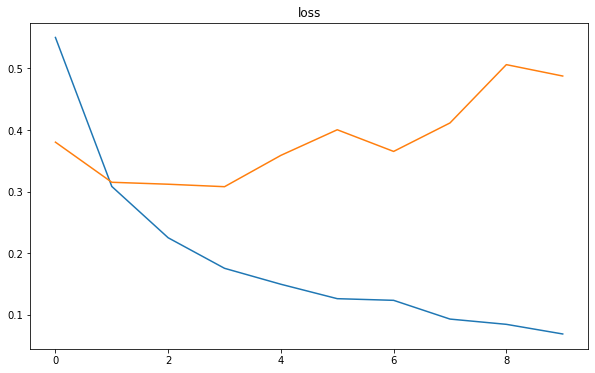

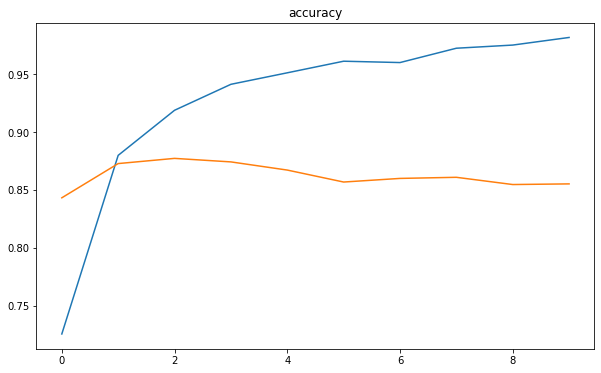

In [ ]:
plot_loss(history_LSTM)

plot_accuracy(history_LSTM)

scores_LSTM = model_LSTM.evaluate(X_test_trim, y_test, verbose=2)
print("%s: %.2f%%" % (model_LSTM.metrics_names[1], scores_LSTM[1]*100))

In [ ]:
# GRU model 

model_GRU = keras.models.Sequential()
model_GRU.add(keras.layers.Embedding(input_dim=num_words, output_dim=10))
model_GRU.add(keras.layers.GRU(units=16))
model_GRU.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model_GRU.compile(loss='binary_crossentropy', optimizer="adam", metrics=["accuracy"])

model_GRU.summary()

Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_32 (Embedding)    (None, None, 10)          100000    
                                                                 
 gru_12 (GRU)                (None, 16)                1344      
                                                                 
 dense_32 (Dense)            (None, 1)                 17        
                                                                 
Total params: 101,361
Trainable params: 101,361
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history_GRU = model_GRU.fit(X_train_trim, y_train,
                    epochs=10, batch_size=128, validation_data=(X_valid_trim, y_valid))

Epoch 1/10
196/196 [==============================] - 54s 261ms/step - loss: 0.5503 - accuracy: 0.7024 - val_loss: 0.3493 - val_accuracy: 0.8528
Epoch 2/10
196/196 [==============================] - 49s 252ms/step - loss: 0.2951 - accuracy: 0.8818 - val_loss: 0.3204 - val_accuracy: 0.8681
Epoch 3/10
196/196 [==============================] - 50s 253ms/step - loss: 0.2253 - accuracy: 0.9145 - val_loss: 0.3222 - val_accuracy: 0.8730
Epoch 4/10
196/196 [==============================] - 49s 252ms/step - loss: 0.1829 - accuracy: 0.9338 - val_loss: 0.3559 - val_accuracy: 0.8670
Epoch 5/10
196/196 [==============================] - 50s 256ms/step - loss: 0.1509 - accuracy: 0.9479 - val_loss: 0.3671 - val_accuracy: 0.8595
Epoch 6/10
196/196 [==============================] - 50s 258ms/step - loss: 0.1301 - accuracy: 0.9569 - val_loss: 0.3841 - val_accuracy: 0.8590
Epoch 7/10
196/196 [==============================] - 51s 258ms/step - loss: 0.1125 - accuracy: 0.9640 - val_loss: 0.4297 - val_ac

391/391 - 10s - loss: 0.5003 - accuracy: 0.8522 - 10s/epoch - 27ms/step
accuracy: 85.22%


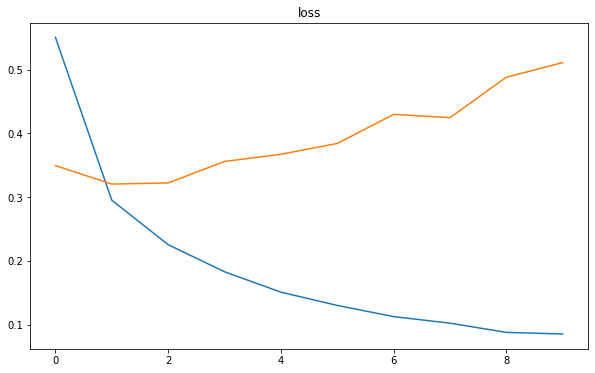

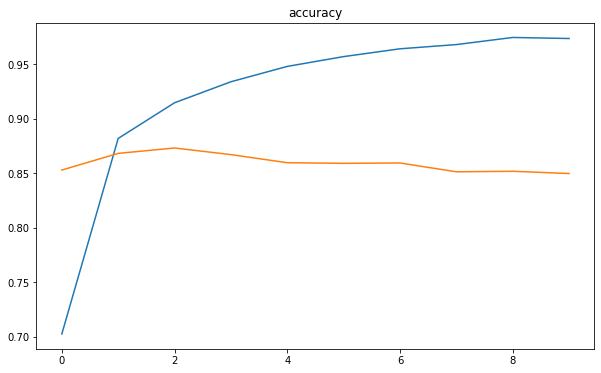

In [ ]:
plot_loss(history_GRU)

plot_accuracy(history_GRU)

scores_GRU = model_GRU.evaluate(X_test_trim, y_test, verbose=2)
print("%s: %.2f%%" % (model_GRU.metrics_names[1], scores_GRU[1]*100))

In the end, using approximately the same number of parameters we achieved the following accuracy scores:
* 81.78% with the simple RNN model;
* 85.84% with the LSTM model;
* 85.22% with the GRU model.

Both GRU and LSTM models outperformed the simple RNN.\
Interestingly enough, as we already noted before the GRU model achieved an accuracy score quite similar to the one achieved by the LSTM model, but using slightly less parameters.\
In this case though the training times were also quite similar, so LSTM can be considered the better alternative.


### Bidirectional LSTM
In conclusion, let's also have a look at the performances of a bidirectional LSTM instead of a simple LSTM. In Keras, it is possible to define a bidirectional layer by using [tf.keras.layers.Bidirectional](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Bidirectional). Note that this wrapper requires as argument a layer, in our case we use [tf.keras.layers.LSTM](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM)


In [ ]:
model_bidirectional = keras.models.Sequential()
model_bidirectional.add(keras.layers.Embedding(input_dim=num_words, output_dim=10))
model_bidirectional.add(keras.layers.Bidirectional(keras.layers.LSTM(32)))
model_bidirectional.add(keras.layers.Dense(1, activation="sigmoid"))

model_bidirectional.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

model_bidirectional.summary()

history = model_bidirectional.fit(X_train_trim, y_train,
                    epochs=5, batch_size=128, validation_data=(X_valid_trim, y_valid))

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_26 (Embedding)    (None, None, 10)          100000    
                                                                 
 bidirectional (Bidirectiona  (None, 64)               11008     
 l)                                                              
                                                                 
 dense_26 (Dense)            (None, 1)                 65        
                                                                 
Total params: 111,073
Trainable params: 111,073
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
196/196 [==============================] - 127s 628ms/step - loss: 0.5068 - accuracy: 0.7387 - val_loss: 0.3756 - val_accuracy: 0.8373
Epoch 2/5
196/196 [==============================] - 121s 616ms/step - loss: 0.2645 - accuracy: 0.89

391/391 - 22s - loss: 0.4301 - accuracy: 0.8660 - 22s/epoch - 56ms/step
accuracy: 86.60%


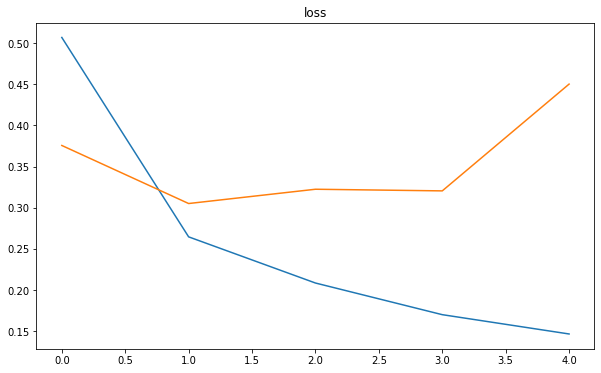

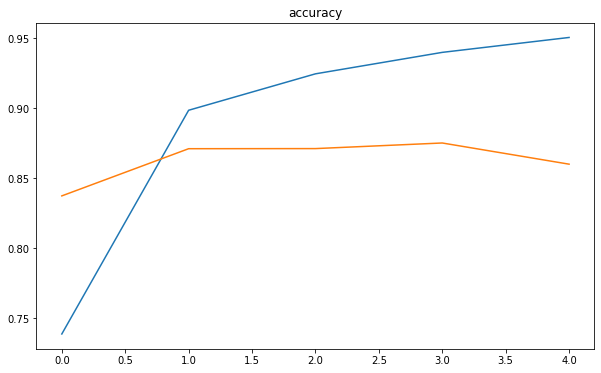

In [ ]:
plot_loss(history)

plot_accuracy(history)

scores = model_bidirectional.evaluate(X_test_trim, y_test, verbose=2)
print("%s: %.2f%%" % (model_bidirectional.metrics_names[1], scores[1]*100))

## Exercise 4.3: Transformer

Let's now use a [Transformer](https://arxiv.org/abs/1706.03762) to perform the same task considered in the previous exercise. To define the Transformer we will define a class that inherits from [tensorflow.keras.layers.Layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Layer). This class represents a layer, that is a callable object that takes as input one or more tensors and that outputs one or more tensors. It involves computation, defined in the `call()` method, and a state (weight variables), both defined in the constructor. In the following cell, we will override these two methods in order to define the TransformerLayer. 

The structure of the transformer is defined as follows:
*   A multi-head attention layer, defined using the [tensorflow.keras.layers.MultiHeadAttention](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MultiHeadAttention)
*   Dropout operation (*dropout_att*)
*   Layer Normalization (*layernorm_att*)
*   A feedforward Neural Network, defenid by using keras.Sequential, and Dense layer
*   Dropout operation (*dropout_fnn*)
*   Layer Normalization (*layernorm_fnn*) that has in input the summation of the attention layer output and the feedforward NN output



In [ ]:
from tensorflow.keras import layers

class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm_att = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm_fnn = layers.LayerNormalization(epsilon=1e-6)
        self.dropout_att = layers.Dropout(rate)
        self.dropout_fnn = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout_att(attn_output, training=training)
        out1 = self.layernorm_att(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout_fnn(ffn_output, training=training)
        return self.layernorm_fnn(out1 + ffn_output)

Due to memory constraints of Transformers the maxlen is reduced to 200.

In [ ]:
maxlen = 200
X_train_trim = keras.preprocessing.sequence.pad_sequences(X_train, maxlen=maxlen)
X_test_trim = keras.preprocessing.sequence.pad_sequences(X_test, maxlen=maxlen)
X_valid_trim = keras.preprocessing.sequence.pad_sequences(X_valid, maxlen=maxlen)

To manage the sequential structure of the input, we need to create an embedding of the word + a positional embedding. To perform this operation, similarly to what we did for defining the Transformer layer, we define a new class that inherits from *layer.Layers*. In the unbatched (i.e. single-input) version, this class has in input the index of a word and computes 2 embeddings: the embedding of the word, and the positional embedding. Finally, the method returns the summation of these two embeddings.

In [ ]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

Now we can define the Transformer model. The model is defined as follows:

*   the Input layer
*   the TokenAndPositionEmbedding layer
*   the Transformer layer
*   2 Dense layers, the second one is the output layer.


In the following we experiment with the `embed_dim, num_heads, ff_dim` parameters and we discuss the influence they have on the obtained results, considering the accuracy of the output and the time required to perform the training phase.

In [ ]:
embed_dim = 50  # Embedding size for each token
num_heads =  10 # Number of attention heads
ff_dim = 20  # Hidden layer size in feed forward network inside transformer

inputs = layers.Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, num_words, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(20, activation="relu")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
history = model.fit(
    X_train_trim, y_train, batch_size=128, epochs=5, validation_data=(X_valid_trim, y_valid)
)

Epoch 1/5
196/196 [==============================] - 507s 3s/step - loss: 0.4329 - accuracy: 0.7840 - val_loss: 0.2995 - val_accuracy: 0.8709
Epoch 2/5
196/196 [==============================] - 504s 3s/step - loss: 0.2297 - accuracy: 0.9110 - val_loss: 0.3407 - val_accuracy: 0.8616
Epoch 3/5
196/196 [==============================] - 515s 3s/step - loss: 0.1889 - accuracy: 0.9284 - val_loss: 0.3367 - val_accuracy: 0.8640
Epoch 4/5
196/196 [==============================] - 514s 3s/step - loss: 0.1507 - accuracy: 0.9467 - val_loss: 0.3818 - val_accuracy: 0.8609
Epoch 5/5
196/196 [==============================] - 522s 3s/step - loss: 0.1335 - accuracy: 0.9531 - val_loss: 0.4404 - val_accuracy: 0.8564


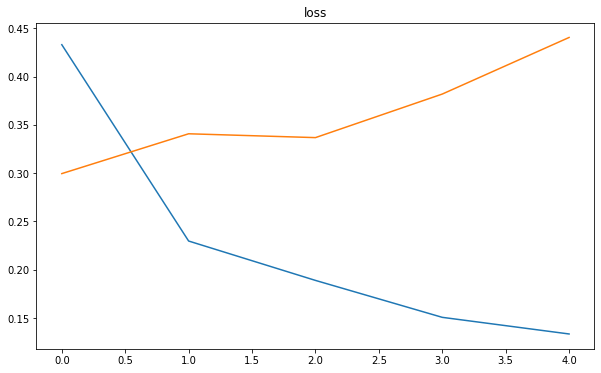

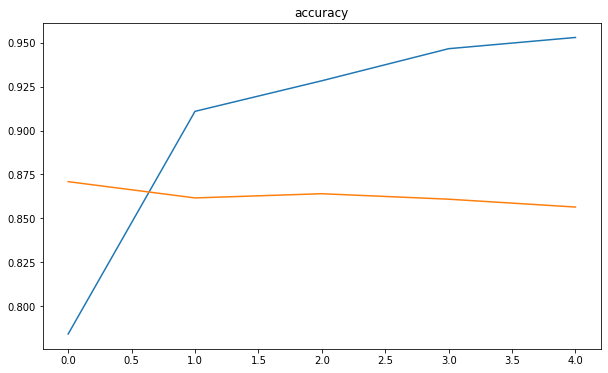

In [ ]:
def plot_loss(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch,history.history['loss'])
  plt.plot(history.epoch,history.history['val_loss'])
  plt.title('loss')

def plot_accuracy(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch,history.history['accuracy'])
  plt.plot(history.epoch,history.history['val_accuracy'])
  plt.title('accuracy')

plot_loss(history)

plot_accuracy(history)

In [ ]:
scores = model.evaluate(X_test_trim, y_test, verbose=2)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

391/391 - 90s - loss: 0.4403 - accuracy: 0.8562 - 90s/epoch - 231ms/step
accuracy: 85.62%


In the following we first briefly report the various model we tested. Each tuple refers to (embed_dim, num_heads, ff_dim).
1. (70, 10, 10) -> accuracy = 85.19%; computing time ~ 1h and 30m;
2. (10, 20, 30) -> accuracy = 85.95%; computing time ~ 45m; 
3. (10, 20, 10) -> accuracy = 85.82%; computing time ~ 40m; 
4. (20, 5, 10) -> accuracy = 84.38%; computing time ~ 15m; 
5. (10, 50, 10) -> accuracy = 85.44%; computing time ~ 2h;
6. (20, 50, 20) -> accuracy = None; computing time > 2h, aborted;
7. (10, 10, 50) -> accuracy = 85.82%; computing time ~ 20m;
8. (10, 10, 70) -> accuracy = 85.82%; computing time ~ 20m;
9. (10, 20, 110) -> accuracy = 84.31%; computing time ~ 40m;
10. (50, 10, 20) -> accuracy = 85.62%; computing time ~ 43m;

From these tests we deduced that: 
- the number of attention heads greatly affects the execution time, way more than the other two parameters. Moreover from our tests comes out that increasing num_heads doesn't even lead to significant improvements in terms of accuracy score. Comparable accuracy levels can be achieved in shorter times varying the other two parameters;
- in particular we noticed that increasing ff_dim led to better performances both in terms of accuracy score and computing time, despite small values of embed_dim and num_heads. Specifically model 7 and 8 were able to achieve almost the maximum achieved accuracy in way less time than the other models.
